In [1]:
# Load dependencies
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:        0 MB


In [2]:
# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models
from unet_wildcat import *

In [3]:
# Helper functions
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [4]:
# Dataloader with paths
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



In [5]:
# Set global properties
num_classes=2
input_size=224
batch_size=64
fold = "fold_INDD119294"
data_dir = "/home/pyushkevich/data/thon2019/exp01/%s" % (fold,)
model_dir="/home/pyushkevich/resnet/thon2019/exp01/%s" % (fold,)

In [6]:
# Read the model
model_ft = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
# model_ft=resnet50_wildcat_upsample(2, pretrained=True, kmax=0.05, kmin=0.02, alpha=0.5, num_maps=2)
model_ft.load_state_dict(torch.load(os.path.join(model_dir, "model_%s_wcu_50_15epoch.dat" % (fold,))))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [7]:
# Create a data loader
dt = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
ds = ImageFolderWithPaths(os.path.join(data_dir, "test"), dt)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4)

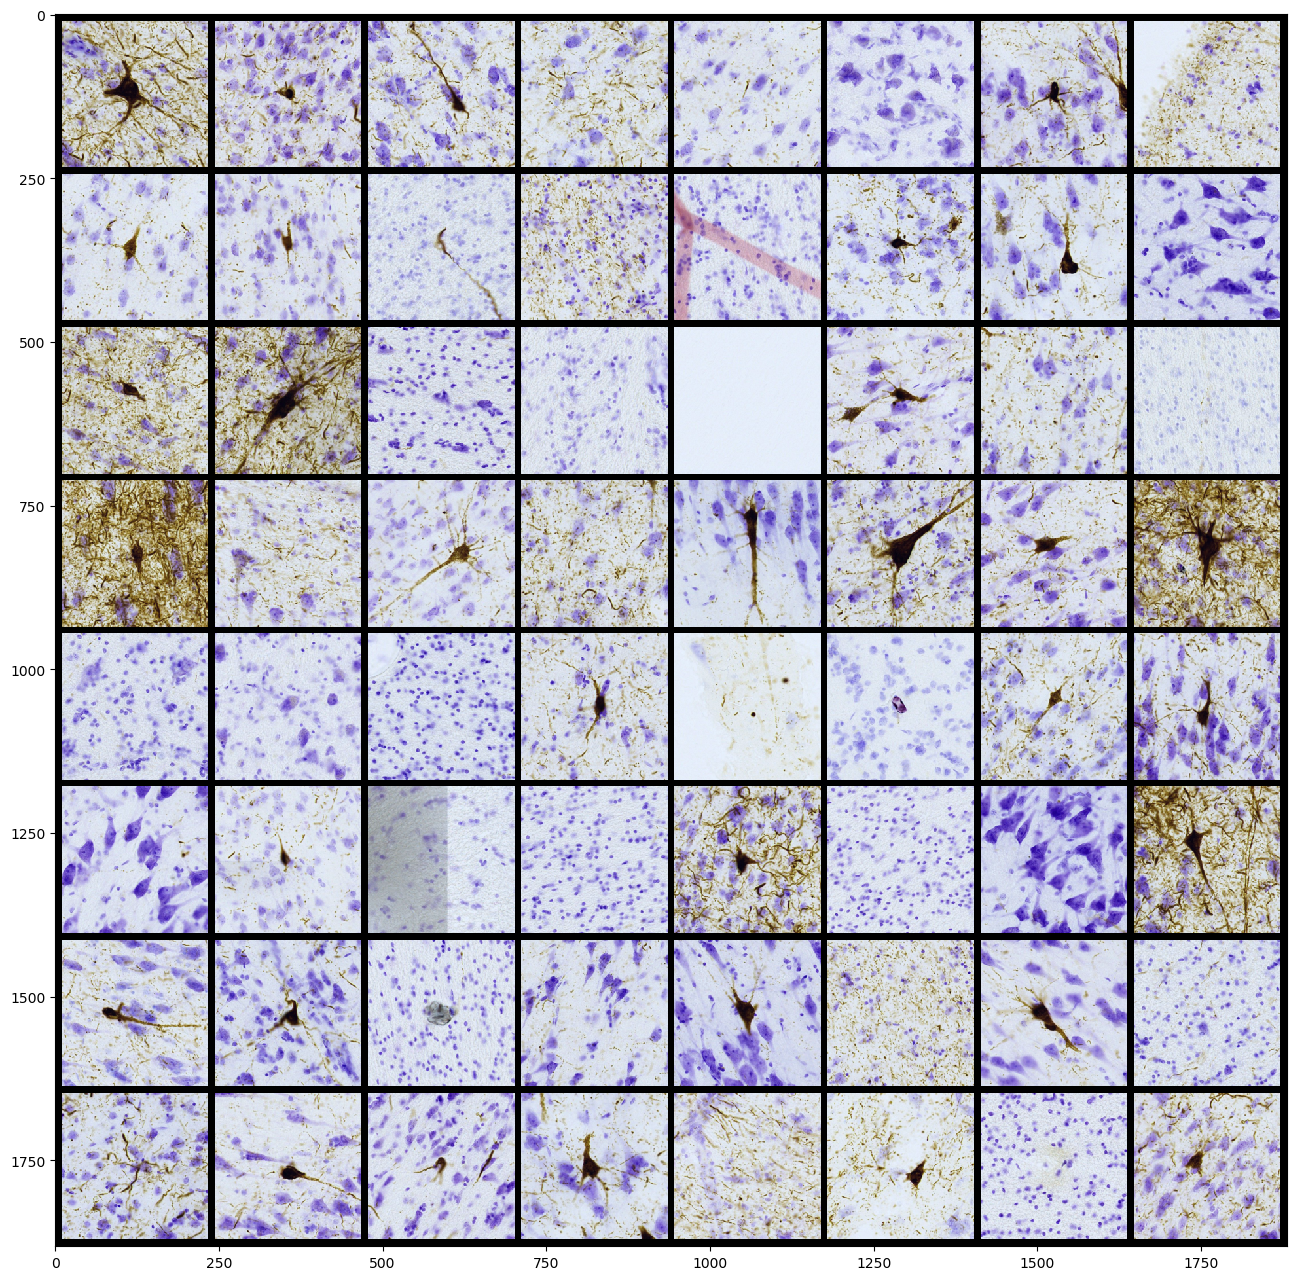

In [57]:

# Read a batch of data
img,label,paths=next(iter(dl))
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img, padding=10, nrow=8, normalize=True))

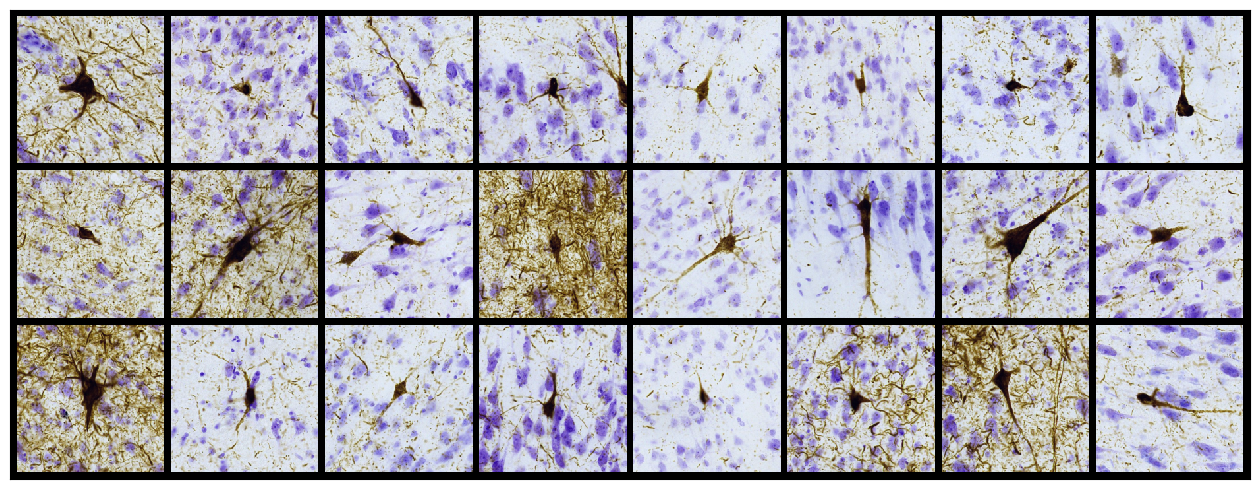

In [58]:
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img[label==1][0:24], padding=10, nrow=8, normalize=True))
plt.tick_params(axis='x',which='both',bottom=False, labelbottom=False)
plt.tick_params(axis='y',which='both',left=False, labelleft=False)
plt.savefig('sshot/examples_tangles_24.png', dpi=300)

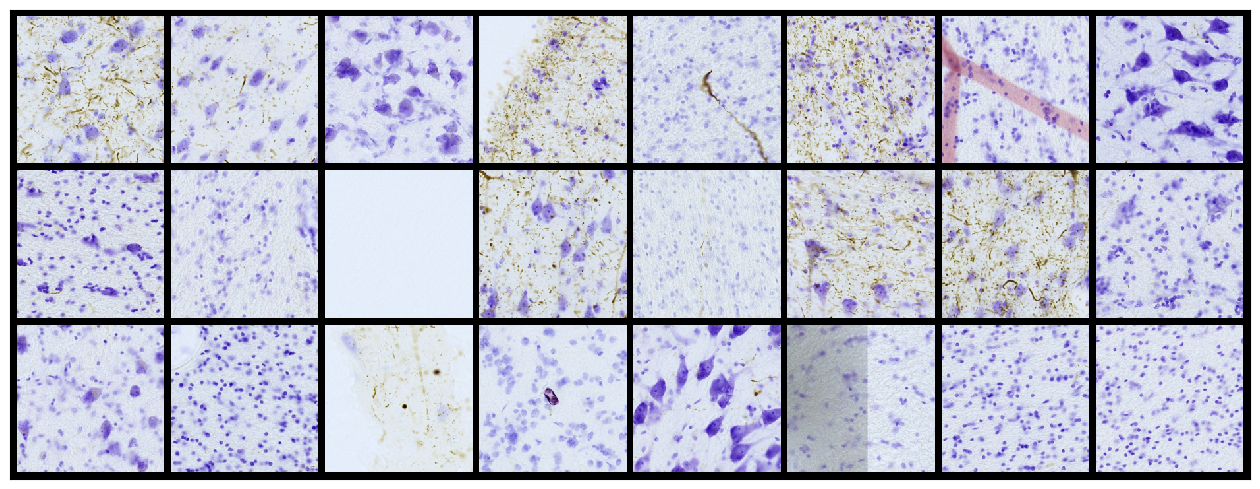

In [59]:
# Evaluate model on this batch
plt.figure(figsize=(16,16))
show(torchvision.utils.make_grid(img[label==0][0:24], padding=10, nrow=8, normalize=True))
plt.tick_params(axis='x',which='both',bottom=False, labelbottom=False)
plt.tick_params(axis='y',which='both',left=False, labelleft=False)
plt.savefig('sshot/examples_nontangles_24.png', dpi=300)

/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


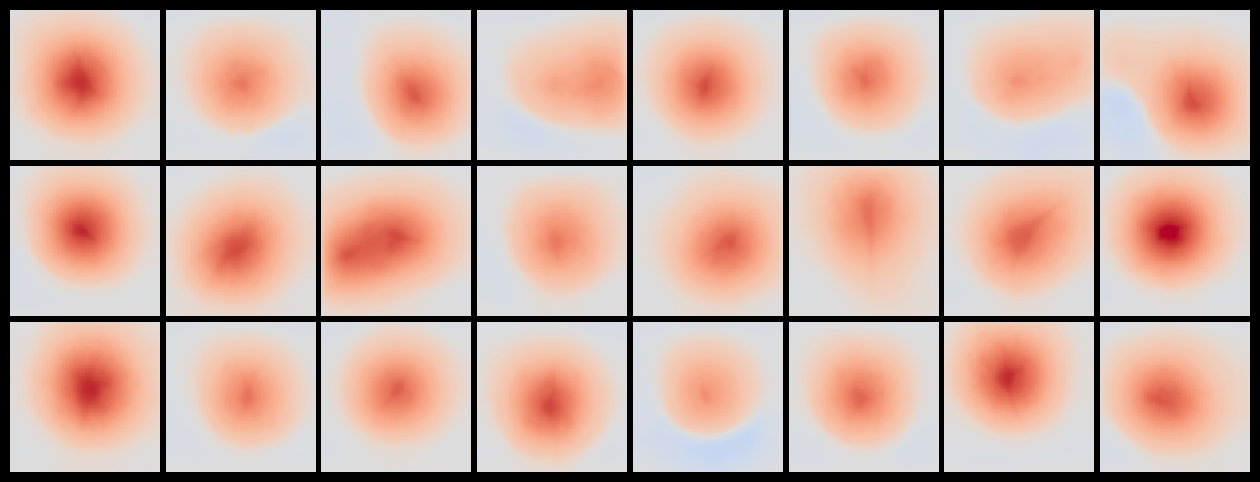

In [62]:
x_clas = model_ft.forward_to_classifier(img[label==1][0:24].cuda())
x_cpool = model_ft.spatial_pooling.class_wise(x_clas)

plt.style.use('dark_background')

dd=x_cpool[:,1,:,:]-x_cpool[:,0,:,:]
fig=plt.figure(figsize=(16,6))
for i in range(24):
    ax=fig.add_subplot(3,8,i+1)
    plt.imshow(dd[i,:,:].detach().cpu().numpy(),plt.get_cmap("coolwarm"), vmin=-16, vmax=16, aspect='auto')
    plt.axis('off')
    ax.set_facecolor('black')
plt.subplots_adjust(wspace=0.04, hspace=0.04)
plt.savefig('sshot/examples_tangles_wcat_24.png', dpi=300)

/home/pyushkevich/miniconda3/envs/histo/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


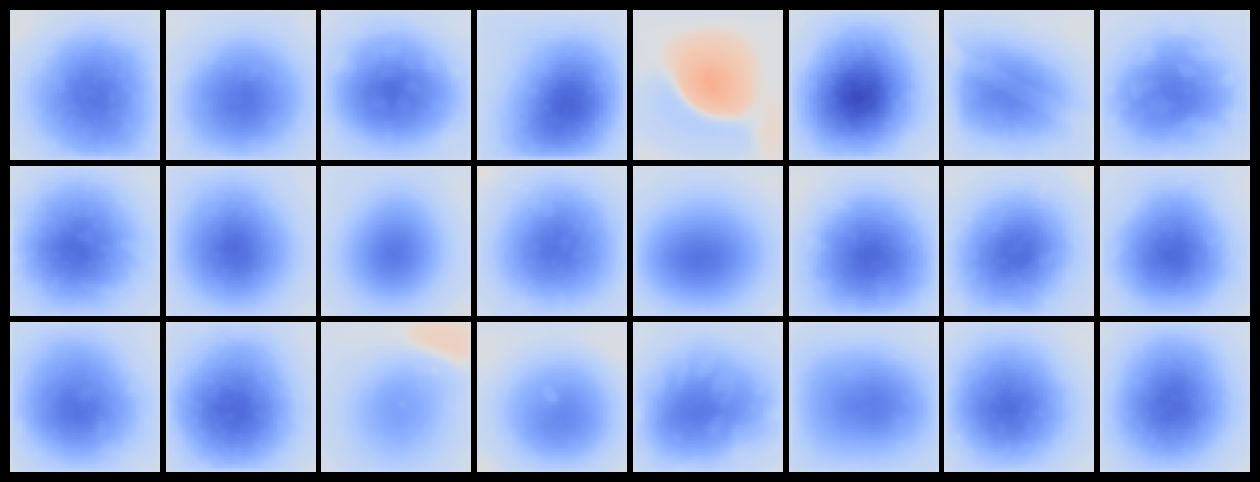

In [61]:
x_clas = model_ft.forward_to_classifier(img[label==0][0:24].cuda())
x_cpool = model_ft.spatial_pooling.class_wise(x_clas)

plt.style.use('dark_background')

dd=x_cpool[:,1,:,:]-x_cpool[:,0,:,:]
fig=plt.figure(figsize=(16,6))
for i in range(24):
    ax=fig.add_subplot(3,8,i+1)
    plt.imshow(dd[i,:,:].detach().cpu().numpy(),plt.get_cmap("coolwarm"), vmin=-16, vmax=16, aspect='auto')
    plt.axis('off')
    ax.set_facecolor('black')
plt.subplots_adjust(wspace=0.04, hspace=0.04)
plt.savefig('sshot/examples_nontangles_wcat_24.png', dpi=300)

In [42]:
img[12,1,:,:].detach().cpu().numpy()

array([[1.9908963 , 1.9033613 , 1.7808123 , ..., 1.8333333 , 1.9208683 ,
        1.7808123 ],
       [2.0259104 , 2.0084033 , 1.9033613 , ..., 1.9208683 , 1.9558823 ,
        1.7457983 ],
       [2.0784314 , 2.0784314 , 2.0609243 , ..., 1.9208683 , 1.3081232 ,
        0.83543426],
       ...,
       [0.83543426, 0.6778712 , 0.74789923, ..., 1.9558823 , 2.0084033 ,
        1.9733893 ],
       [1.5182073 , 1.5357143 , 1.5357143 , ..., 1.9208683 , 1.9558823 ,
        1.6057423 ],
       [1.2556022 , 1.2731093 , 1.4131653 , ..., 2.0259104 , 1.9908963 ,
        1.5532213 ]], dtype=float32)